# Projekt badawczy - Predykcja zakłóceń w łańcuchu dostaw na podstawie kluczowych czynników logistycznych z wykorzystaniem algorytmów uczenia maszynowego (EXtreme Gradient Boosting, LightGBM i regresji logistycznej)

#### W ramach niniejszego projektu przeprowadzono zaawansowaną analizę predykcyjną, której celem było zidentyfikowanie i zrozumienie kluczowych czynników wpływających na zakłócenia w łańcuchu dostaw. Poprzez wykorzystanie metod uczenia maszynowego, projekt pozwala na tworzenie dokładnych prognoz dotyczących ryzyka wystąpienia opóźnień w dostawach oraz problemów z dostępnością produktów, które mogą prowadzić do powstawania tzw. backorderów (opóźnień w realizacji zamówień).

#### Dzięki analizie tych ryzyk, organizacje mogą podjąć działania zapobiegawcze lub dostosowawcze w celu optymalizacji procesów zaopatrzenia i sprzedaży, minimalizując negatywny wpływ takich problemów na wyniki biznesowe. Model predykcyjny oparty na technikach sztucznej inteligencji pozwala na szybsze i bardziej precyzyjne identyfikowanie potencjalnych zagrożeń, dzięki czemu przedsiębiorstwa mogą lepiej reagować na zmieniające się warunki rynkowe, unikając przestojów i utraty przychodów.

#### Do analizy zastosowano trzy algorytmy uczenia maszynowego:

* EXtreme Gradient Boosting (XGBoost),
* Light Gradient Boosting Machine (LightGBM),
* Regresję logistyczną.

#### Do analizy uwzględniono następujące zmienne:
* Y – zmienna docelowa, wskazująca, czy produkt trafił na backorder (opóźnienie w dostawie), (1 – tak, 0 – nie)
* in_transit_qty – liczba produktów w transporcie, czyli tych, które są już wysłane, ale jeszcze nie trafiły do miejsca docelowego
* forecast_3_month – prognoza sprzedaży na 3 miesiące
* sales_1_month – sprzedaż w ostatnim miesiącu
* sales_3_month – sprzedaż w ostatnich 3 miesiącach
* min_bank – minimalny wymagany poziom zapasów
* potential_issue – wskaźnik potencjalnych problemów (np. produkcyjnych, jakościowych, logistycznych)
* pieces_past_due – liczba opóźnionych sztuk produktu
* local_bo_qty – liczba produktów na backorderze
* deck_risk – wskaźnik ryzyka produktu
* oe_constraint – ograniczenia operacyjne
* ppap_risk – ryzyko zatwierdzenia produkcji (PPAP)
* stop_auto_buy – zatrzymanie automatycznych zakupów
* rev_stop – zatrzymanie sprzedaży produktu.

# Analiza statystyczna zmiennych

In [47]:
%%capture
!pip install imbalanced-learn
!pip install numpy
!pip install pandas
!pip install scikit-learn 
!pip install xgboost 
!pip install lightgbm 
!pip install catboost
!pip install joblib
!pip install matplotlib

In [3]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import joblib

### Wczytanie danych

In [4]:
data = pd.read_csv("Went_on_backorder.csv", sep=";")

In [5]:
data.head()

,Y,in_transit_qty,forecast_3_month,sales_1_month,sales_3_month,min_bank,potential_issue,pieces_past_due,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,2,0,0,0,0,0,0,1,0
2,1,0,4,0,0,0,0,0,0,0,0,0,1,0
3,1,0,11,2,2,0,0,0,0,0,0,0,1,0
4,1,0,9,0,0,1,0,0,0,0,0,0,1,0


In [6]:
data.iloc[:,[0,10,11,12,13]] = data.iloc[:,[0,10,11,12,13]].astype(bool)

### Wymiary początkowe tabeli

In [7]:
data.shape

(48286, 14)

### Typy danych

In [8]:
data.dtypes

Y                    bool
in_transit_qty      int64
forecast_3_month    int64
sales_1_month       int64
sales_3_month       int64
min_bank            int64
potential_issue     int64
pieces_past_due     int64
local_bo_qty        int64
deck_risk           int64
oe_constraint        bool
ppap_risk            bool
stop_auto_buy        bool
rev_stop             bool
dtype: object

# Równoważenie zbioru danych

In [9]:
X = data.drop(columns=['Y'])
y = data['Y']

In [10]:
y.value_counts()

Y
False    46104
True      2182
Name: count, dtype: int64

### Rozkład zmiennej zależnej

<Axes: xlabel='Y'>

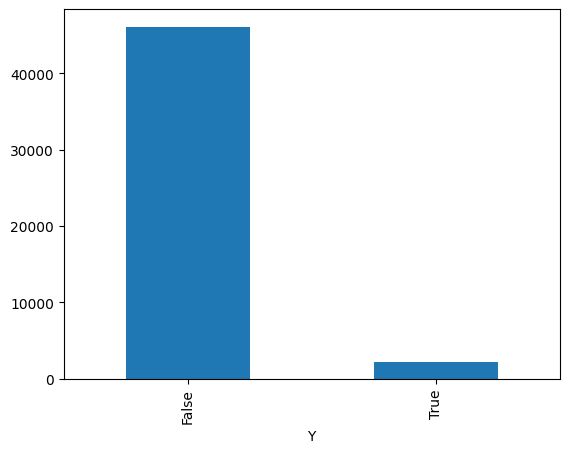

In [11]:
y.value_counts().plot.bar()

### Oversampling - SMOTE

Generowanie nowych przykładów, aby zrównoważyć liczebność klas.

In [12]:
over_SMOTE = SMOTE(random_state=3)
X_over_SMOTE, y_over_SMOTE = over_SMOTE.fit_resample(X, y)

print("Rozmiar danych po równoważeniu:")
print(y_over_SMOTE.value_counts())

Rozmiar danych po równoważeniu:
Y
True     46104
False    46104
Name: count, dtype: int64


In [13]:
total_over_SMOTE = pd.concat([X_over_SMOTE, y_over_SMOTE], axis=1)

In [14]:
total_over_SMOTE.shape

(92208, 14)

# Podział na zbiór treningowy i testowy

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_over_SMOTE, y_over_SMOTE, test_size=0.2, random_state=40)

In [16]:
print("Rozmiar zbioru uczącego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru uczącego: 73766
Rozmiar zbioru testowego: 18442


# Modele

## 1. EXtreme Gradient Boosting

In [17]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Obliczenie wartości AUC dla zbioru treningowego

In [18]:
pred_train = model_xgb.predict_proba(X_train)[:,1]
fpr, tpr, threshold = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)
roc_auc_train

0.9585442983118672

### Obliczenie wartości AUC dla zbioru testowego

In [19]:
pred_test = model_xgb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_test, pred_test)
roc_auc_test

0.9510832503812162

In [20]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

In [22]:
new_row = pd.DataFrame([{'classifiers': 'XGBoost',
                         'fpr': fpr, 
                         'tpr': tpr, 
                         'auc': roc_auc_test}])

result_table = pd.concat([result_table, new_row], ignore_index=True)

### Generowanie krzywych ROC dla modelu na zbiorze treningowym i testowym.

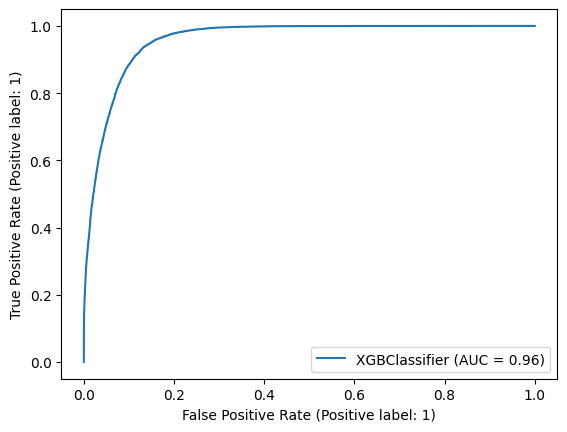

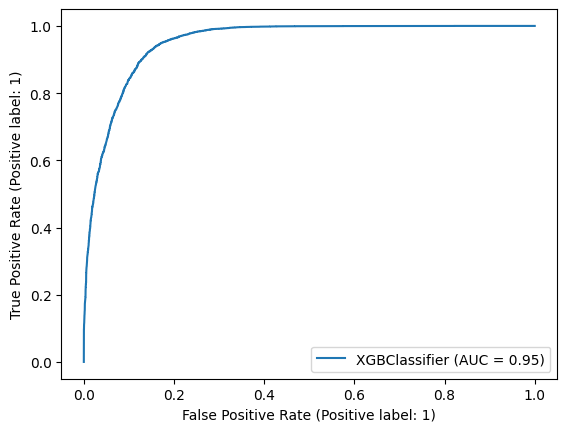

In [31]:
RocCurveDisplay.from_estimator(model_xgb, X_train, y_train)
RocCurveDisplay.from_estimator(model_xgb, X_test, y_test)

### Wizualizacja drzewa w modelu XGBoost

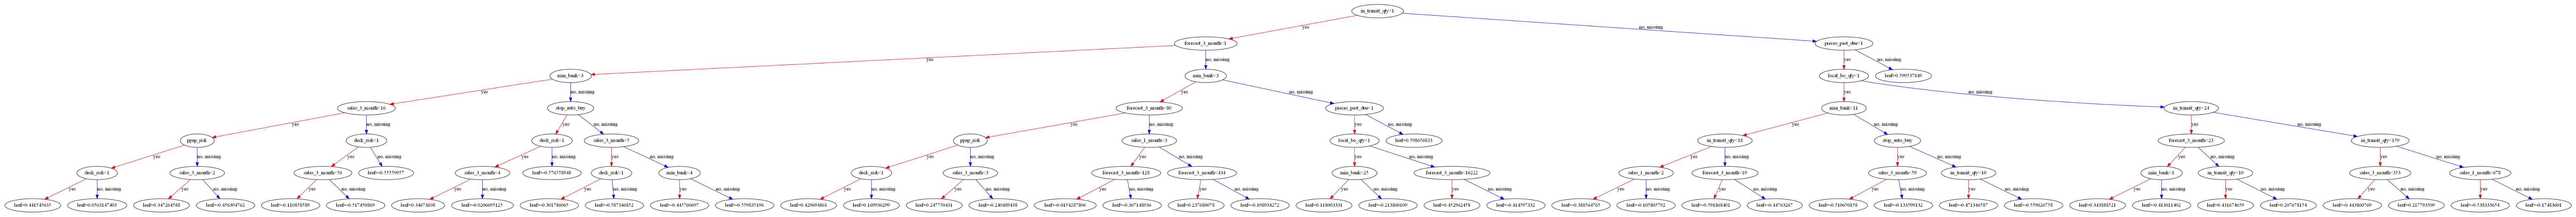

In [30]:
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(model_xgb, num_trees=0, ax=ax)
plt.savefig('drzewo.jpg')
plt.show()

## 2. Light Gradient Boosting Machine

In [32]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 36813, number of negative: 36953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 73766, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499051 -> initscore=-0.003796
[LightGBM] [Info] Start training from score -0.003796


LGBMClassifier()

### Obliczenie wartości AUC dla zbioru treningowego 

In [33]:
pred_train = model_lgb.predict_proba(X_train)[:,1]
fpr, tpr, threshold = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)
roc_auc_train

0.9404352078484366

### Obliczenie wartości AUC dla zbioru testowego

In [34]:
pred_test = model_lgb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_test, pred_test)
roc_auc_test

0.9371713826199286

In [36]:
new_row = pd.DataFrame([{
    'classifiers': 'LightGBM',
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': roc_auc_test
}])

result_table = pd.concat([result_table, new_row], ignore_index=True)


### Generowanie krzywych ROC dla modelu na zbiorze treningowym i testowym.

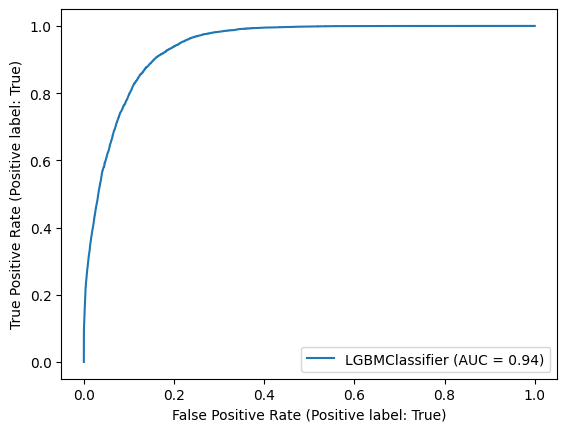

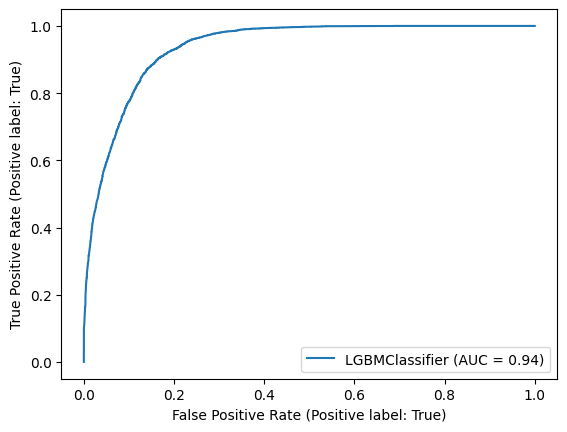

In [37]:
RocCurveDisplay.from_estimator(model_lgb, X_train, y_train)
RocCurveDisplay.from_estimator(model_lgb, X_test, y_test)

### Wizualizacja drzewa dla modelu Light Gradient Boosting Machine

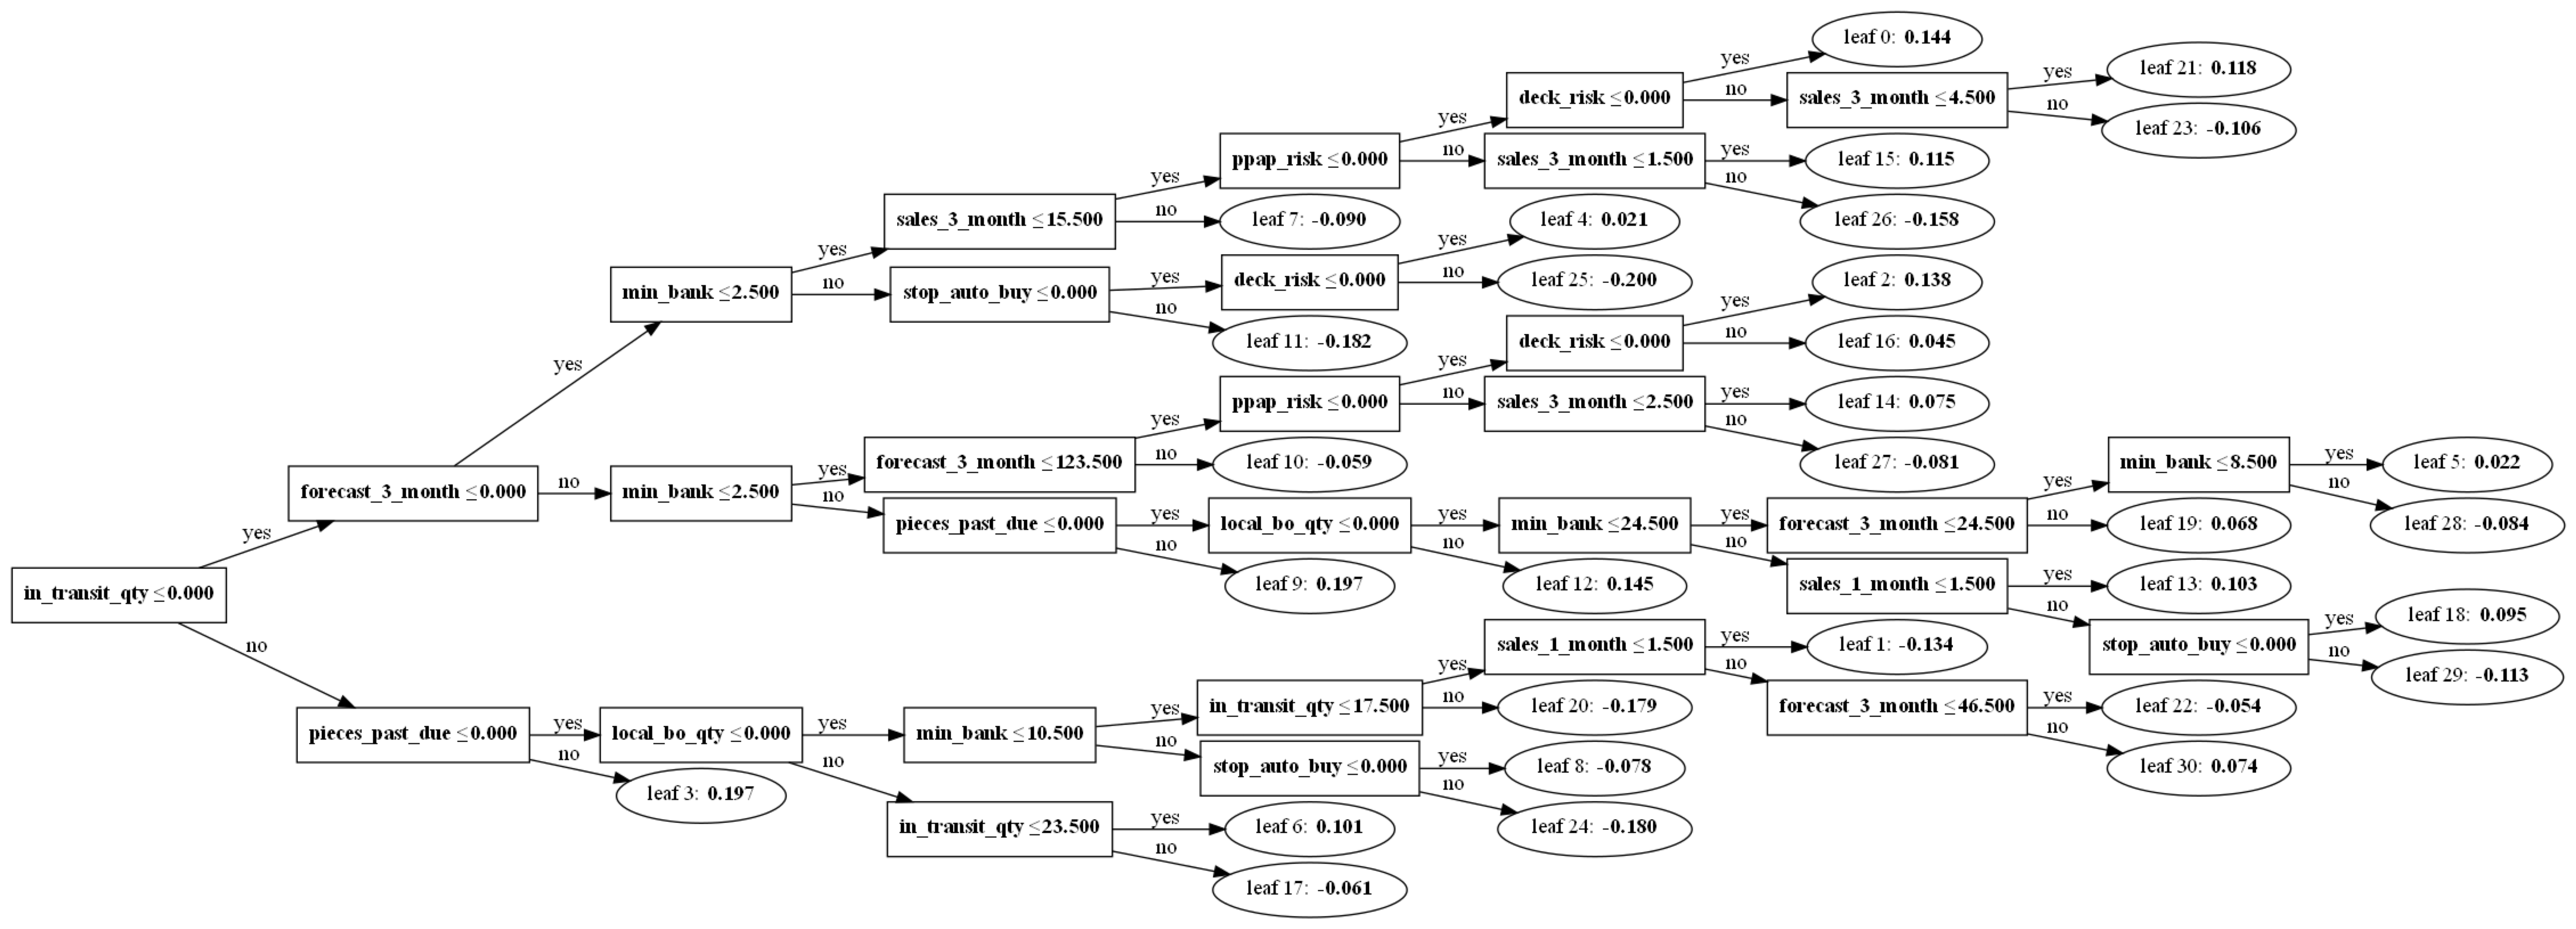

In [38]:
lgb.plot_tree(model_lgb, tree_index = 0, figsize=(200,20))
plt.savefig('drzewo1.jpg')

## 3. Logistic Regression

In [39]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

C:\Users\Klaudia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Obliczenie wartości AUC dla zbioru treningowego

In [40]:
pred_train = model_lr.predict_proba(X_train)[:,1]
fpr, tpr, threshold = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)
roc_auc_train

0.8389716084473856

### Obliczenie wartości AUC dla zbioru testowego

In [41]:
pred_test = model_lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_test, pred_test)
roc_auc_test

0.8430189920034876

In [43]:
new_row = pd.DataFrame([{
    'classifiers': 'LogReg',
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': roc_auc_test
}])

result_table = pd.concat([result_table, new_row], ignore_index=True)


# Ewaluacja modeli

In [44]:
result_table.head()

,classifiers,fpr,tpr,auc
0,XGBoost,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021526208158432892, 0.00032289312237...",0.951083
1,LightGBM,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010763104079216446, 0.00043052416316...",0.937171
2,LogReg,"[0.0, 0.00010927767457108513, 0.00010927767457...","[0.0, 0.041653212786567646, 0.0419761059089441...",0.843019


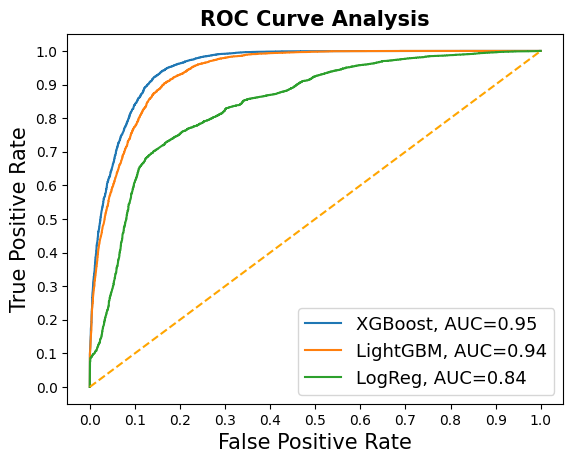

In [45]:
result_table.set_index('classifiers', inplace=True)

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### Rekomendacja:

##### Spośród modeli eXtreme Gradient Boosting, Light Gradient Boosting Machine oraz Logistic Regression najlepszy okazał się model eXtreme Gradient Boosting.
##### AUC dla tego modelu było najwyższe i wyniosło 0,95.
##### Niewiele gorzej spisał się również model LightGBM, którego AUC wyniosło 0.94.
##### Regresja logistyczna w tym wypadku nie jest zalecana.

##### Na wizualizacjach drzew modeli można zauważyć, iż zbiór dzielony jest z udziałem tych samych cech, jednakże rozpoznane wartości deliatnie różnią się. 
##### Początkowo zbiór dzielony jest wg cechy in_transit_qty, która jest większa lub mniejsza niż 1 wg XGBoost a dla LightGBM wartością tą jest 0. 
##### Sytuacja wygląda identycznie przy kolejnym podziale, wg cechy forecast_3_month i pieces_past_due. Jednakże drzewa wyglądają bardzo podobnie. 

### Interpretowalność rekomendowanego modelu

##### Im wyższa wartość AUC, tym lepiej model rozróżnia między przypadkami poprawnie sklasyfikowanymi jako prawdziwe oraz fałszywie sklasyfikowanych jako prawdziwe.
##### Bardzo wysoka wartość AUC dla zbioru treningowego wynosząca 0.96 oznacza, że klasyfikator XGBoost bardzo dobrze radzi sobie z rozróżnianiem klas.
##### Praktycznie taka sama wartość w zbiorze testowym świadczy o tym, iż model jest bardzo dobrze nauczony i potrafi generalizować nowe dane, zatem z powodzeniem znajdzie praktyczne zastosowanie w przewidywaniu przyszłych oczekujących zamówień.


### Interpretacja wyników końcowych:

##### Analiza wskazała, że liczba produktów w transporcie (in_transit_qty) jest kluczowym czynnikiem predykcyjnym w badanym modelu.
##### Model dokonuje pierwszego podziału na podstawie tego, czy liczba produktów w transporcie przekracza 1.
##### Jeśli TAK (więcej produktów w transporcie) -> Produkt ma większą szansę na brak problemów z dostępnością.
##### Jeśli NIE -> Model analizuje następne czynniki.
##### Kolejnymi kluczowymi zmiennymi okazały się być: prognoza sprzedaży na 3 miesiące (forecast_3_month) oraz opóźnione dostawy (pieces_past_due).
##### Jeśli prognoza sprzedaży jest wysoka, a produktów w transporcie mało -> ryzyko backorderu rośnie.